# Refactor with gollum

We just did a significant overhaul with moving to gollum for preprocessing, settling with pseudo-Voigt, and 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

from gollum.phoenix import PHOENIXSpectrum
import astropy.units as u

In [2]:
spec = PHOENIXSpectrum(teff=4700, logg=4.5).divide_by_blackbody().normalize()

Let's do a running percentile.

In [3]:
continuum, coeffs = spec.fit_continuum(polyorder=5, return_coeffs=True)

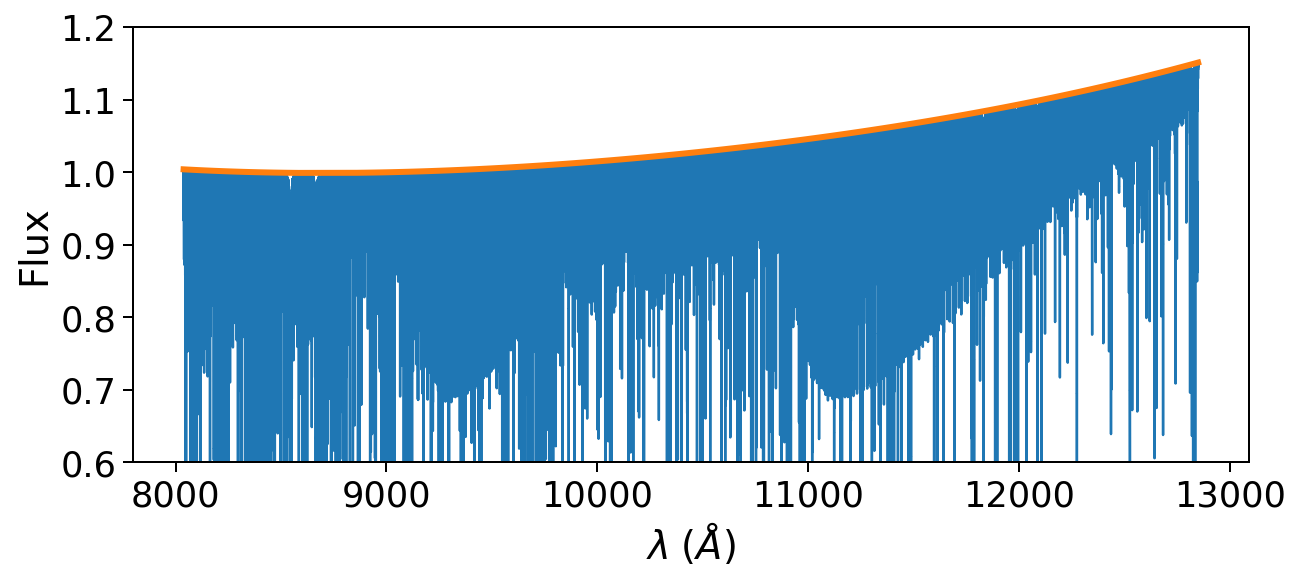

In [4]:
ax = spec.plot()
continuum.plot(ax=ax, lw=3);

Nice! Great continuum fitting in this case...

In [5]:
flattened_spec = spec.divide(continuum, handle_meta='ff')

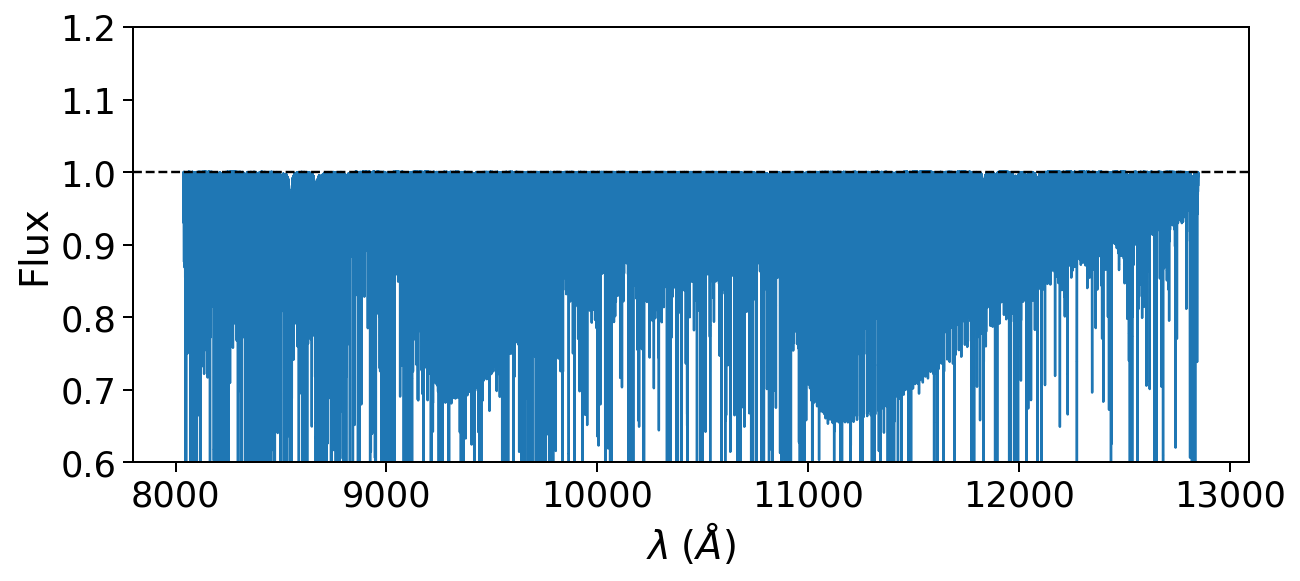

In [6]:
ax = flattened_spec.plot()
ax.axhline(1.0, linestyle='dashed', color='k');

In [7]:
x_vector = flattened_spec.wavelength.value
y_vector = flattened_spec.flux.value

# Emulator

In [8]:
import torch

In [9]:
from blase.emulator import PhoenixEmulator

In [10]:
! ls -t1 ../examples/*.pt

../examples/native_res_0p1prom.pt


In [11]:
! du -hs '../examples/native_res_0p1prom.pt'

208K	../examples/native_res_0p1prom.pt


In [12]:
with torch.no_grad():
    model_params = torch.load('../examples/native_res_0p1prom.pt')

In [13]:
model_params

OrderedDict([('amplitudes',
              tensor([-4.7866, -4.3060, -4.5106,  ..., -4.6055, -5.2681, -5.6138],
                     device='cuda:0', dtype=torch.float64)),
             ('sigma_widths',
              tensor([-3.6783, -3.3629, -3.5574,  ..., -2.9496, -3.0476, -3.4261],
                     device='cuda:0', dtype=torch.float64)),
             ('gamma_widths',
              tensor([-3.0345, -3.2495, -3.3910,  ..., -2.7546, -2.7794, -2.9218],
                     device='cuda:0', dtype=torch.float64)),
             ('lam_centers',
              tensor([ 8038.5800,  8040.0900,  8040.8900,  ..., 12845.8000, 12847.4600,
                      12847.9400], device='cuda:0', dtype=torch.float64)),
             ('a_coeff', tensor(1., device='cuda:0', dtype=torch.float64)),
             ('b_coeff', tensor(0., device='cuda:0', dtype=torch.float64)),
             ('c_coeff', tensor(0., device='cuda:0', dtype=torch.float64))])

In [14]:
len(model_params['amplitudes'])

6527

In [15]:
bad_mask = (model_params['amplitudes']>0)

In [16]:
bad_mask.sum()

tensor(2, device='cuda:0')

In [17]:
model_params['amplitudes'][bad_mask] = 0

In [18]:
emulator = PhoenixEmulator(x_vector, y_vector, prominence=0.02,)

In [19]:
emulator.load_state_dict(model_params)

<All keys matched successfully>

This step takes a *TON* of RAM unless you use `torch.no_grad`!

Even then, we can run out of RAM.  We may have to resort to stacking.

In [20]:
emulator.wl_native

tensor([ 8038.0100,  8038.0200,  8038.0300,  ..., 12848.9400, 12848.9600,
        12848.9800], dtype=torch.float64)

In [21]:
sub_divisions = 20

In [22]:
n_wl = len(emulator.wl_native)

In [23]:
wl_blocks = []
for i in range(0, sub_divisions):
    start = i*n_wl//sub_divisions
    if i == (sub_divisions-1):
        end = None
    else:
        end = (i+1)*n_wl//sub_divisions
    this_wl = emulator.wl_native[start:end]
    wl_blocks.append(this_wl)

In [24]:
cloned_spectra = []
with torch.no_grad():
    for wl_block in wl_blocks:
        this_spectrum = emulator.forward(wl_block)
        cloned_spectra.append(this_spectrum)

In [25]:
cloned_spectrum = torch.cat(cloned_spectra)

In [26]:
type(cloned_spectrum), cloned_spectrum.shape

(torch.Tensor, torch.Size([338649]))

## $\pm 1.96\%$ residuals with a long tail

At native resolution

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

In [28]:
indices = np.isin(emulator.wl_native, emulator.lam_centers.detach())

from scipy.ndimage import binary_dilation

dilated_inds = binary_dilation(indices, iterations=2)

dilated_inds

array([False, False, False, ..., False, False, False])

In [29]:
indices.sum(), dilated_inds.sum(), len(x_vector)

(6527, 32635, 338649)

(10820.0, 10960.0)

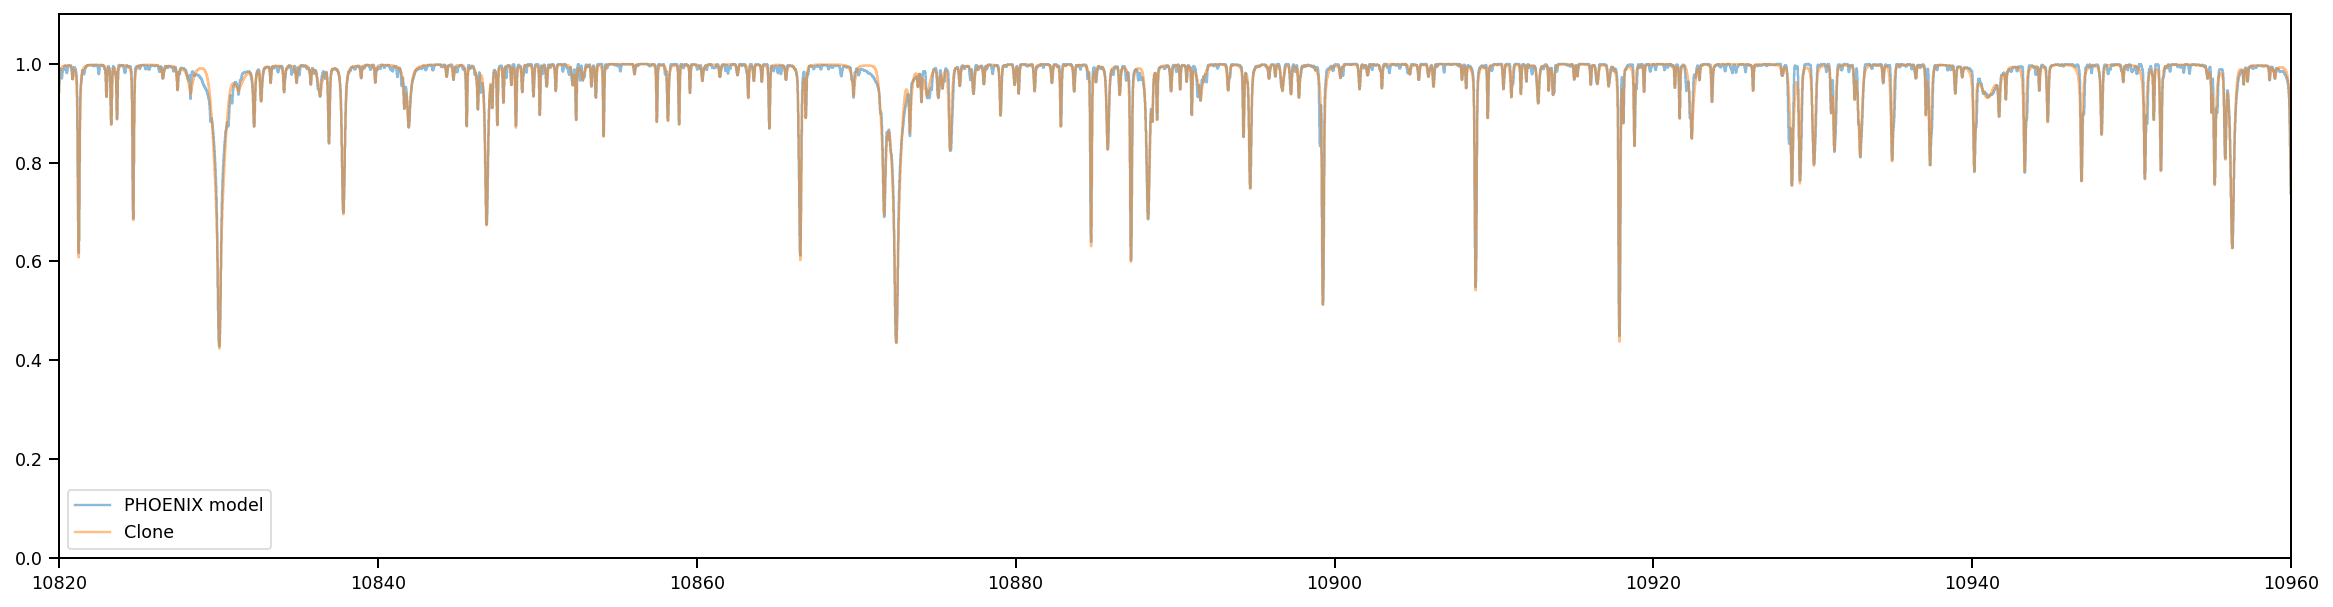

In [69]:
plt.figure(figsize=(20, 5))
plt.step(emulator.wl_native, emulator.flux_native, label='PHOENIX model', alpha=0.5)
plt.step(emulator.wl_native, cloned_spectrum.detach(), label='Clone', alpha=0.5)
plt.legend()
plt.ylim(0, 1.1)
#plt.xlim(8_450, 8_600)
#plt.xlim(10_000, 10_010)
#plt.xlim(10_900, 11_010)
plt.xlim(10820, 10960)

The deep broad-line-wing lines should be treated separately...

In [31]:
residual = emulator.flux_native - cloned_spectrum.detach()

In [32]:
stddev = torch.std(residual)

Text(0, 0.5, 'Residual (%)')

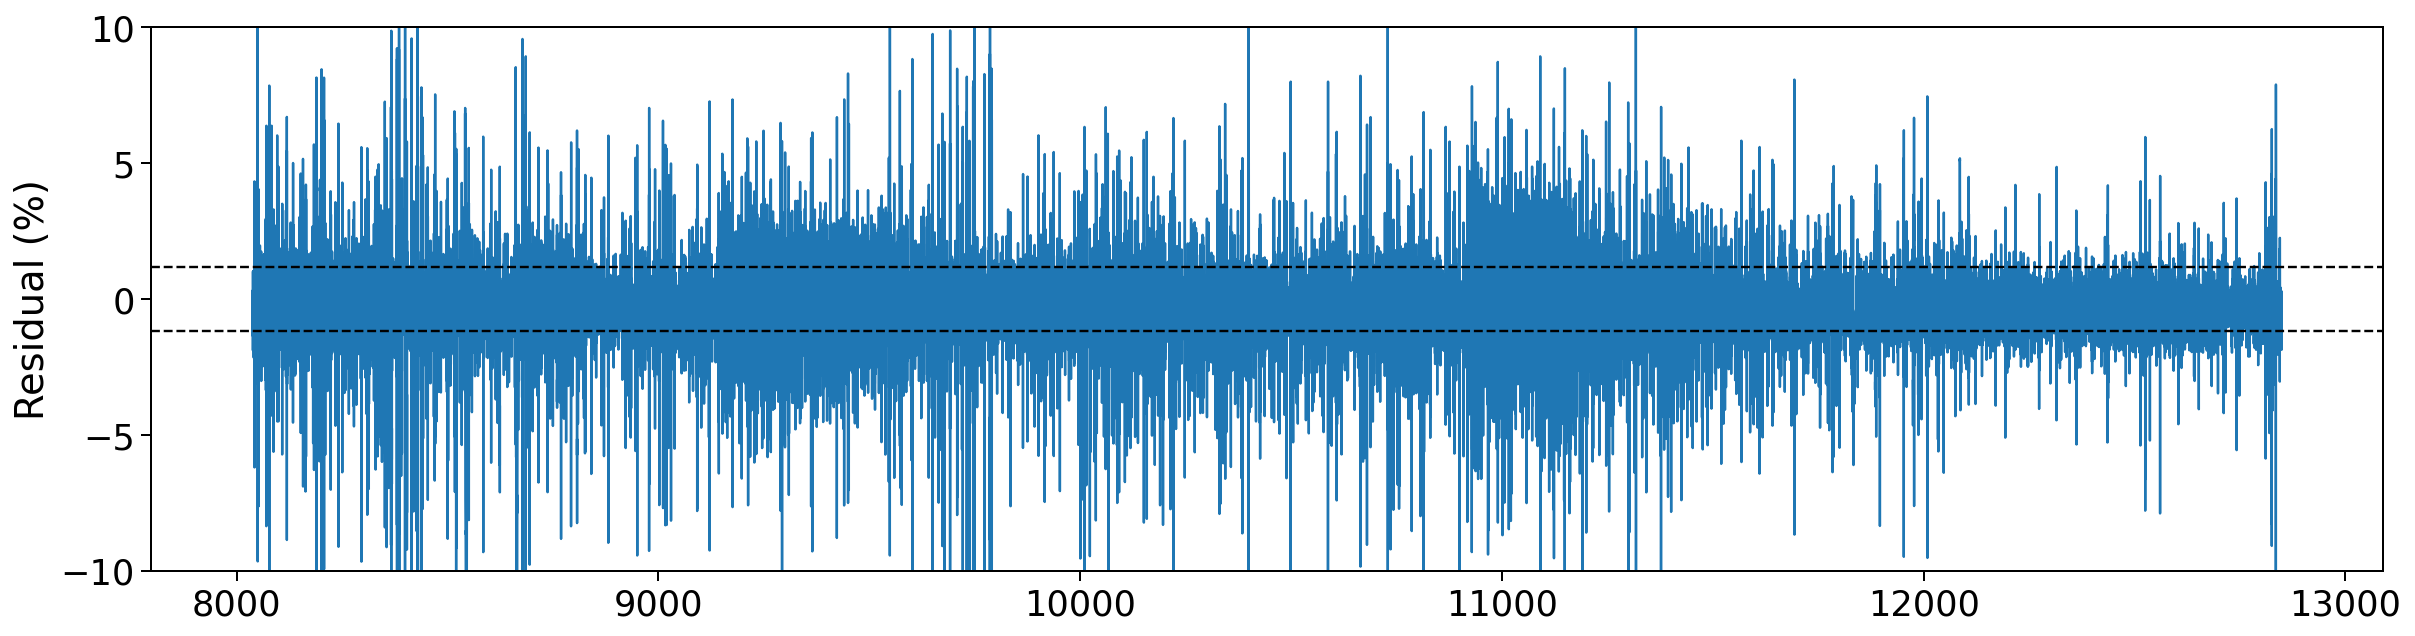

In [33]:
plt.figure(figsize=(20, 5))
plt.plot(emulator.wl_native, residual*100.0, label='Residual')
plt.axhline(+stddev*100, color='k', linestyle='dashed')
plt.axhline(-stddev*100, color='k', linestyle='dashed')
plt.ylim(-10, 10)
plt.ylabel('Residual (%)')

In [34]:
stddev

tensor(0.0117, dtype=torch.float64)

Hmmm, those residuals seem large compared to the reported residuals after training... did something go wrong when we loaded them in?  Is there some hysteresis when loading a model?  A rounding error?

How big are the residuals when you smooth them to HPF resolution?

## Smooth to HPF resolution

In [35]:
from gollum.phoenix import PHOENIXSpectrum
import astropy.units as u

from muler.hpf import HPFSpectrumList

In [36]:
original_native = PHOENIXSpectrum(spectral_axis=emulator.wl_native*u.Angstrom, 
                                flux=emulator.flux_native*u.dimensionless_unscaled)

In [37]:
clone_native = PHOENIXSpectrum(spectral_axis=emulator.wl_native*u.Angstrom, 
                                flux=cloned_spectrum*u.dimensionless_unscaled)

In [38]:
echelle_orders = HPFSpectrumList.read('../../muler_example_data/HPF/01_A0V_standards/Goldilocks_20210517T054403_v1.0_0060.spectra.fits')

In [39]:
hpf_spectrum = echelle_orders.sky_subtract(method='vector')\
                                .deblaze()\
                                .normalize()\
                                .remove_nans()\
                                .trim_edges((6,2042))\
                                .stitch()

In [40]:
def simulate_observation(spectrum):
    """Simulate an observation with HPF"""
    return spectrum.rotationally_broaden(4.5)\
                    .rv_shift(0.0)\
                    .instrumental_broaden(resolving_power=55_000)\
                    .resample(hpf_spectrum)

In [41]:
original_sim = simulate_observation(original_native)
clone_sim = simulate_observation(clone_native)

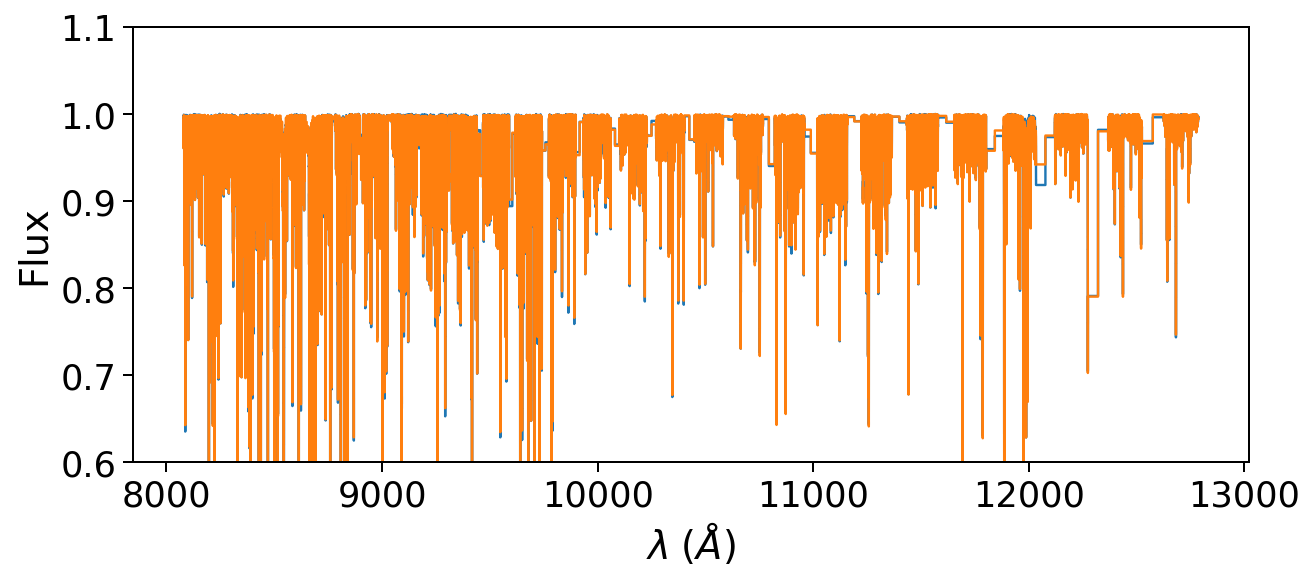

In [42]:
ax = original_sim.plot(ylo=0.6, yhi=1.1)
clone_sim.plot(ax=ax);

(10820.0, 10960.0)

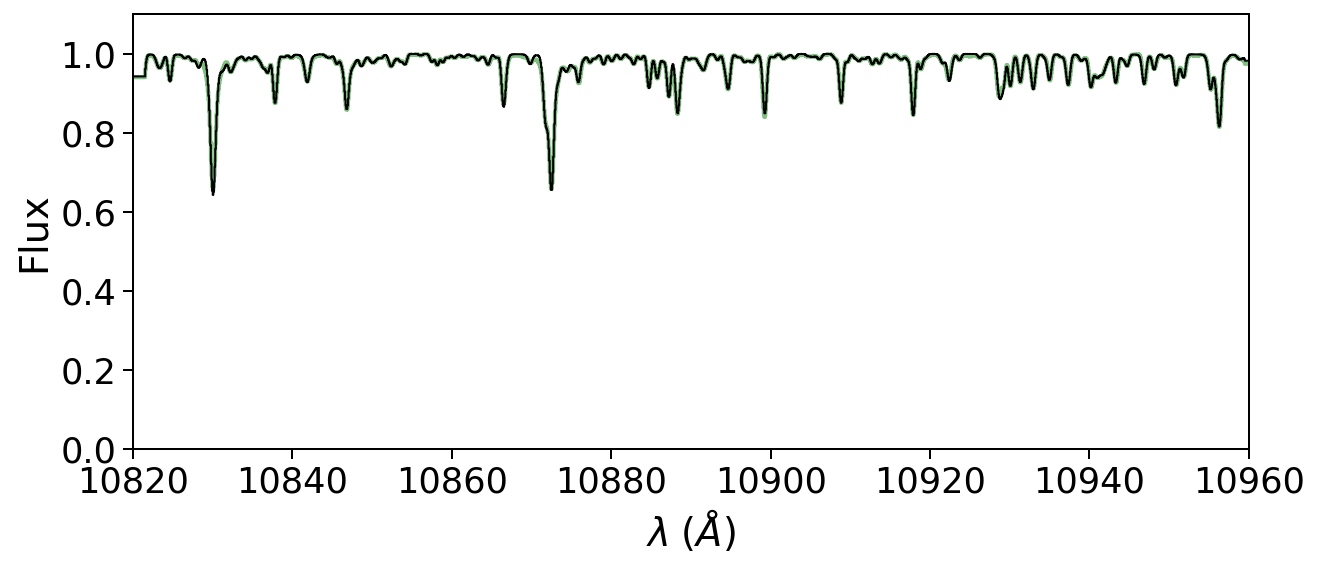

In [44]:
ax = original_sim.plot(ylo=0.0, yhi=1.1, color='g', lw=2, alpha=0.5)
clone_sim.plot(ax=ax, color='k', lw=1)
ax.plot()
ax.set_xlim(10820, 10960)
#plt.xlim(10_900, 11_010)
#plt.xlim(10_900, 11_010)

The cloning is OK, but not great.

In [45]:
residual_spec = (original_sim - clone_sim)*100

In [46]:
stddev = residual_spec.flux.std().value

In [47]:
stddev

0.695142066174132

## $\pm 0.6\%$ residuals after smoothing and resampling


Text(0, 0.5, 'Residual (%)')

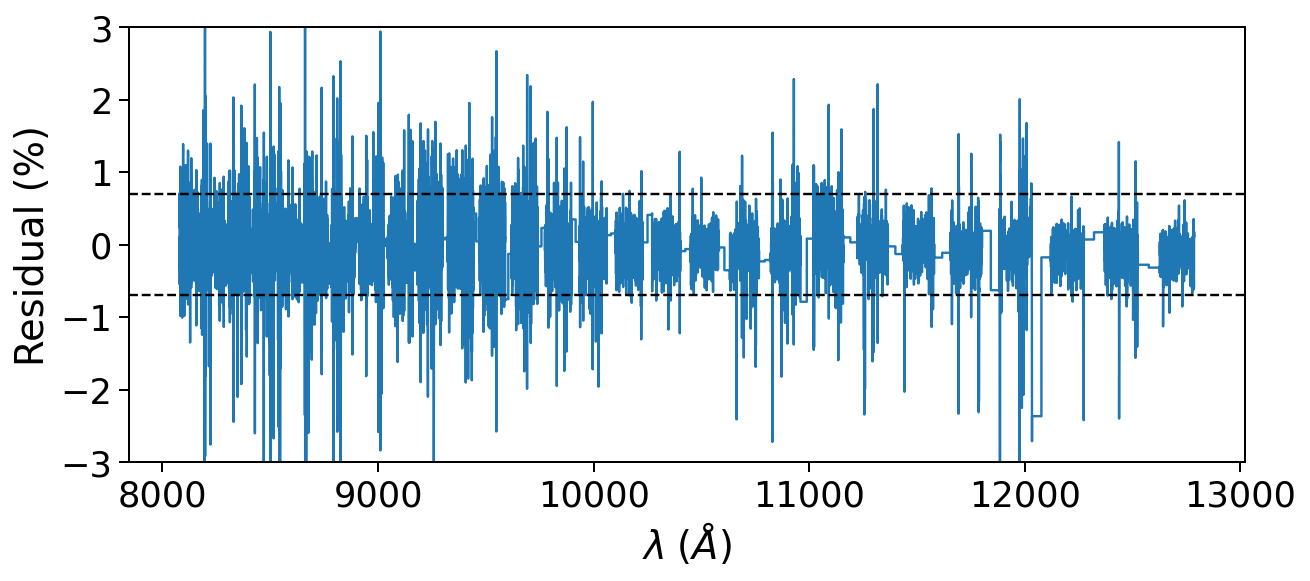

In [48]:
ax = residual_spec.plot(ylo=-3, yhi=3)
ax.axhline(+stddev, color='k', linestyle='dashed')
ax.axhline(-stddev, color='k', linestyle='dashed')
ax.set_ylabel('Residual (%)')

In [51]:
(lam_centers_init, amplitudes_init, widths_angstroms_init,) = emulator.detect_lines(
            emulator.wl_native, emulator.flux_native, prominence=0.02
        )

In [52]:
lam_centers_init, amplitudes_init, widths_angstroms_init = (lam_centers_init.cpu().numpy(),
                                                            amplitudes_init.cpu().numpy(), 
                                                            widths_angstroms_init.cpu().numpy())

In [53]:
amplitudes_post = torch.exp(model_params['amplitudes']).cpu().numpy()

In [54]:
sigma_widths_post = torch.exp(model_params['sigma_widths']).cpu().numpy()

In [55]:
gamma_widths_post = torch.exp(model_params['gamma_widths']).cpu().numpy()

In [56]:
lam_centers_post = model_params['lam_centers'].cpu().numpy()

In [57]:
lam_centers_post

array([ 8038.58,  8040.09,  8040.89, ..., 12845.8 , 12847.46, 12847.94])

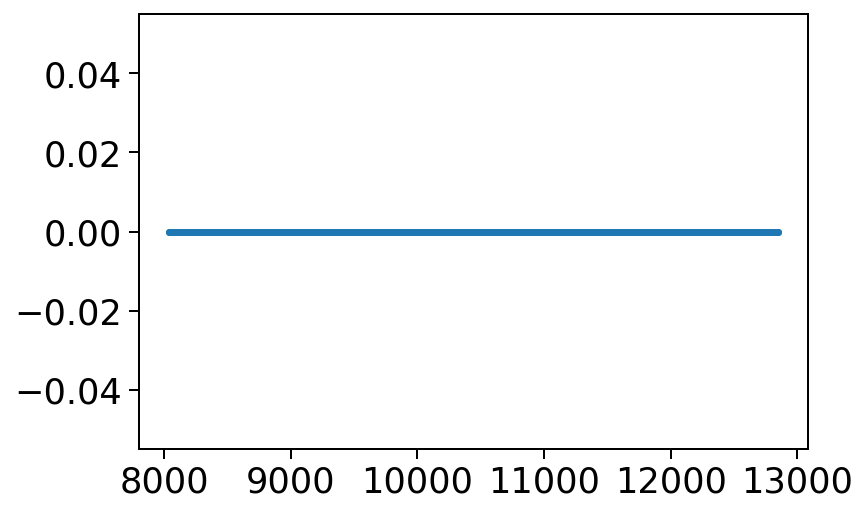

In [58]:
plt.plot(lam_centers_init, lam_centers_post-lam_centers_init, '.');

In [59]:
sns.set_context('paper')

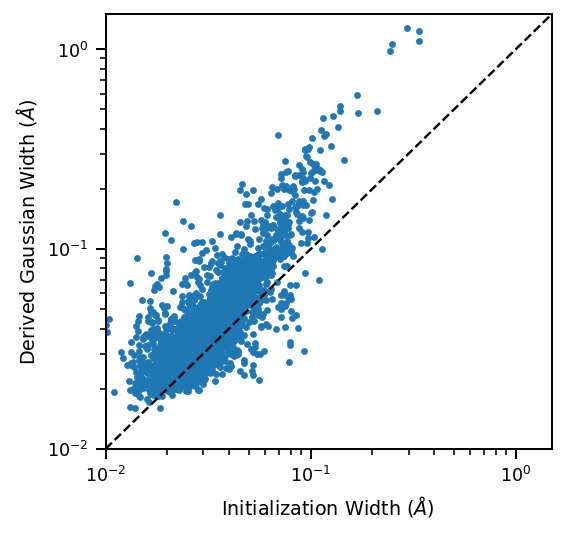

In [60]:
plt.figure(figsize=(4,4))
plt.plot(widths_angstroms_init/np.sqrt(2), sigma_widths_post, '.');
plt.plot([0.01, 1.5], [0.01, 1.5], linestyle='dashed', color='k')
plt.xlabel('Initialization Width $(\AA)$ ')
plt.ylabel('Derived Gaussian Width $(\AA)$')
plt.xlim(0.01, 1.5)
plt.ylim(0.01, 1.5)
plt.xscale('log')
plt.yscale('log')

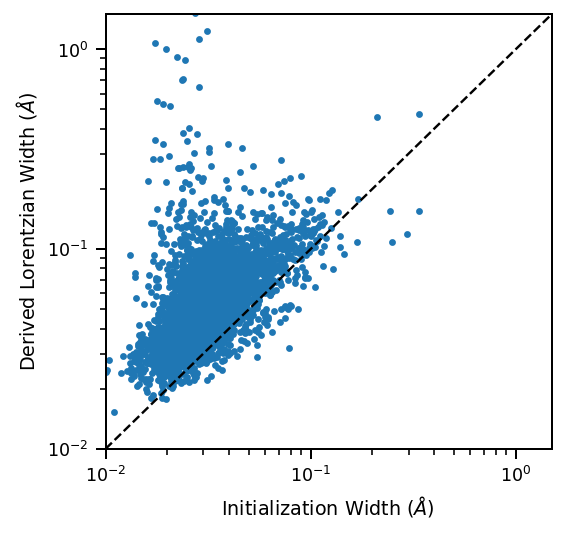

In [61]:
plt.figure(figsize=(4,4))
plt.plot(widths_angstroms_init/np.sqrt(2), gamma_widths_post, '.');
plt.plot([0.01, 1.5], [0.01, 1.5], linestyle='dashed', color='k')
plt.xlabel('Initialization Width $(\AA)$ ')
plt.ylabel('Derived Lorentzian Width $(\AA)$')
plt.xlim(0.01, 1.5); plt.ylim(0.01, 1.5)
plt.xscale('log'); plt.yscale('log')

In [62]:
np.median(sigma_widths_post / (widths_angstroms_init/np.sqrt(2)))

1.3501488636445744

In [63]:
np.median(gamma_widths_post / (widths_angstroms_init/np.sqrt(2)))

1.5114298253111713

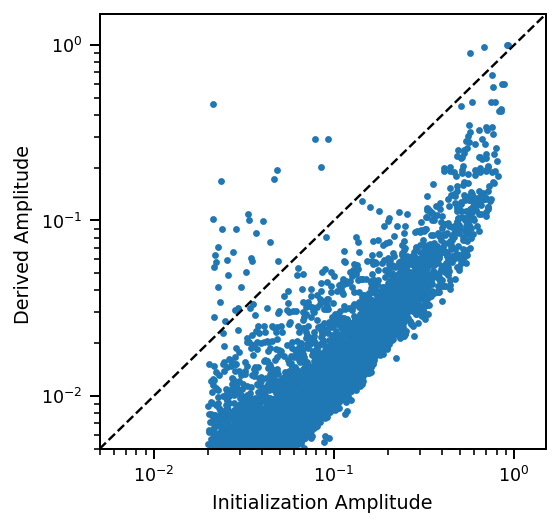

In [64]:
plt.figure(figsize=(4,4))
plt.plot(amplitudes_init, amplitudes_post, '.');
plt.plot([0.005, 1.5], [0.005, 1.5], linestyle='dashed', color='k')
plt.xlabel('Initialization Amplitude')
plt.ylabel('Derived Amplitude ')
plt.xlim(0.005, 1.5); plt.ylim(0.005, 1.5)
plt.xscale('log'); plt.yscale('log')

In [65]:
np.median(amplitudes_post / amplitudes_init)

0.13013936535080692

## How to get better performance?

1. ~~More flexible continuum~~ **Done!** (We pre-flatten)     
It should be like 5-20th order polynomial, or a GP

2. Longer training  
More like 1500 epochs, not 300

3. Better handling of deep lines with broad linewings  
Some more-flexible line shapes for those.

4. ~~Better initialization~~ **Done!**  
Make a heuristic for where the lines start with amplitude/width and where they end up.

5. Incorporate lower prominence lines  
This is currently a computation problem, sort-of.  We can go deeper it just takes longer.